<a href="https://colab.research.google.com/github/Neha-Baranwal/Deep_Learning_Workshop/blob/main/simple_graph_nn_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
The notebook is mainly done for my own benefit to better understand what graph convolutional networks do on a very basic tasks like triangles and 3x3 convolutions
The notebook uses the [Spektral](https://github.com/danielegrattarola/spektral) package for running the models.

## Install Dependencies

In [ ]:
# !apt-get install -y graphviz libgraphviz-dev libcgraph6

In [ ]:
# !pip install git+https://github.com/danielegrattarola/spektral

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.util import montage
from IPython.display import Image, display, SVG, clear_output, HTML
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better
import networkx as nx
def draw_graph_mpl(g, 
                   pos=None, 
                   ax=None, 
                   layout_func=nx.drawing.layout.kamada_kawai_layout, 
                   draw_labels=True,
                   figsize=(5, 5)
                  ):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = None
    if pos is None:
        pos = layout_func(g)
    node_color = []
    node_labels = {}
    shift_pos = {}
    for k in g:
        node_color.append(g.nodes[k].get('color', 'green'))
        node_labels[k] = g.nodes[k].get('label', k)
        shift_pos[k] = [pos[k][0], pos[k][1]]
    
    edge_color = []
    edge_width = []
    edge_labels = {}
    for e in g.edges():
        edge_color.append(g.edges[e].get('color', 'black'))
        edge_width.append(g.edges[e].get('width', 0.5))
        edge_labels[e] = g.edges[e].get('label', '')
    
    nx.draw_networkx_edges(g, pos, style='solid', edge_color=edge_color, width=edge_width, alpha=0.5, ax=ax)
    if any([len(x)>0 for x in edge_labels.values()]):
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, ax=ax)
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_shape='o', node_size=800, alpha=0.25, ax=ax)
    if draw_labels:
        nx.draw_networkx_labels(g, pos, labels=node_labels,  ax=ax)
    ax.autoscale()
    return fig, ax, pos

# Simple Graph

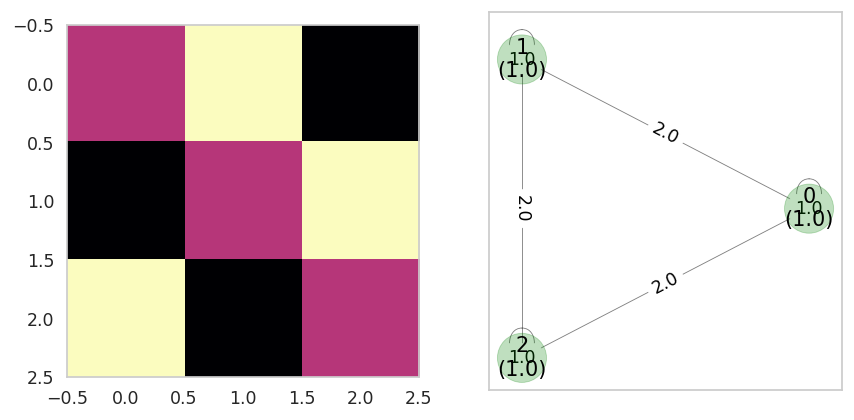

In [ ]:
tri_adj = np.eye(3)
for i in range(3):
    tri_adj[i, (i+1) % tri_adj.shape[0]] = 2
    #tri_adj[(i+1) % tri_adj.shape[1],i] = 0.5
tri_node = np.ones((3, 1))
G = nx.from_numpy_array(tri_adj)

for k, pix_val in zip(G.nodes, tri_node):
    G.nodes[k]['label'] = '{}\n({:1.1f})'.format(k, pix_val[0])
for i,j in zip(*np.where(tri_adj>0)):
    G.edges[(i, j)]['label'] = '{:1.1f}'.format(tri_adj[i, j])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(tri_adj, cmap='magma')
draw_graph_mpl(G, ax=ax2);

# Build Graph NN Models

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from spektral.datasets import mnist
from spektral.layers import GCNConv as GraphConv
from spektral.utils.sparse import sp_matrix_to_sp_tensor
from spektral.utils import normalized_laplacian

In [ ]:
# Model definition
X_in = Input(shape=(None, 1))
# Pass A as a fixed tensor, otherwise Keras will complain about inputs of
# different rank.
A_in = Input(shape=(None, None))
graph_conv_1 = GraphConv(1, 
                         activation='linear',
                         use_bias=False,
                         weights=[1*np.ones((1, 1))]
                        )([X_in, A_in])
model = Model(inputs=[X_in, A_in], outputs=[graph_conv_1])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, None)] 0                                            
__________________________________________________________________________________________________
gcn_conv (GCNConv)              (None, None, 1)      1           input_1[0][0]                    
                                                                 input_2[0][0]                    
Total params: 1
Trainable params: 1
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
def show_model_results(in_node, 
                       in_adj, 
                       model, 
                       max_val=5, 
                       pos=None,
                       figsize=(16, 4)
                      ):
    fig, m_axs = plt.subplots(1, 4, figsize=figsize)
    c_node = in_node.copy()
    ax1, *n_axs = m_axs
    ax1.imshow(in_adj, cmap='magma')
    G = nx.from_numpy_array(in_adj)
    for i,j in zip(*np.where(in_adj>0)):
        if i!=j:
            G.edges[(i, j)]['label'] = '{:1.1f}'.format(in_adj[i, j])
    ax1.set_title('Adjacency')
    for i, c_ax in enumerate(n_axs, 0):
        for j, pix_val in zip(G.nodes, c_node):
            G.nodes[j]['label'] = '#{}\n({:1.1f})'.format(j, pix_val[0])
            G.nodes[j]['color'] = plt.cm.magma(pix_val[0]/max_val)
        _, _, pos = draw_graph_mpl(G, ax=c_ax, pos=pos);
        c_ax.set_title('Pass #{}'.format(i) if i>0 else 'Input')
        c_node = model.predict([c_node[None,], in_adj[None,]])[0]

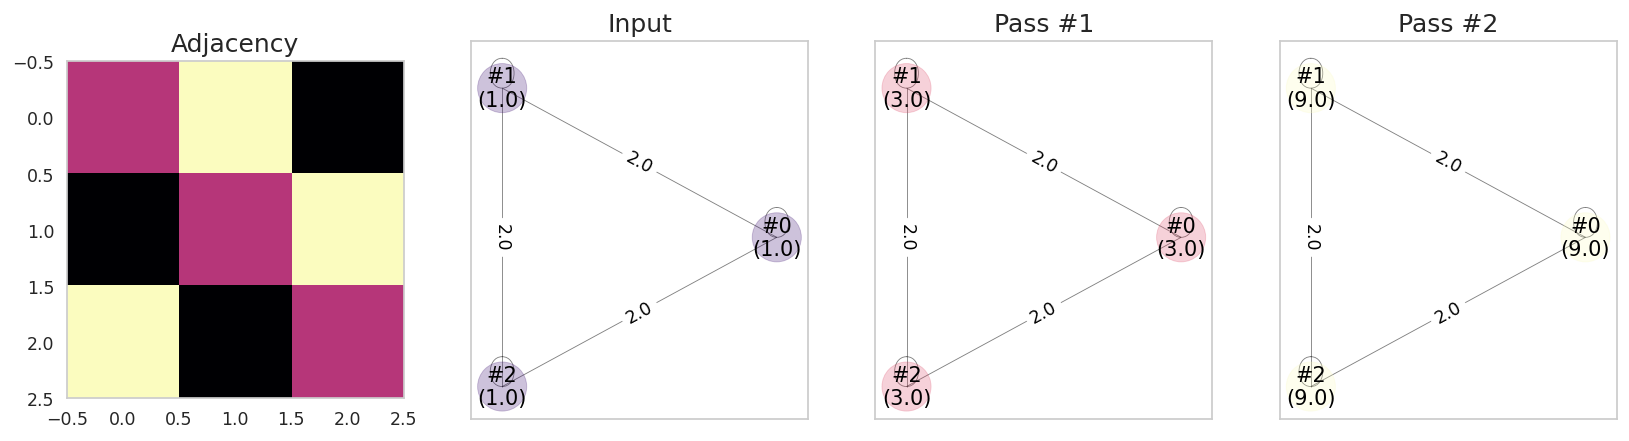

In [ ]:
show_model_results(tri_node, tri_adj, model)

## Propogate and decay
Here we have an simple graph where the edges only pass the value to the next node and decay the value by 25%. For the results we see the nodes "rotating"

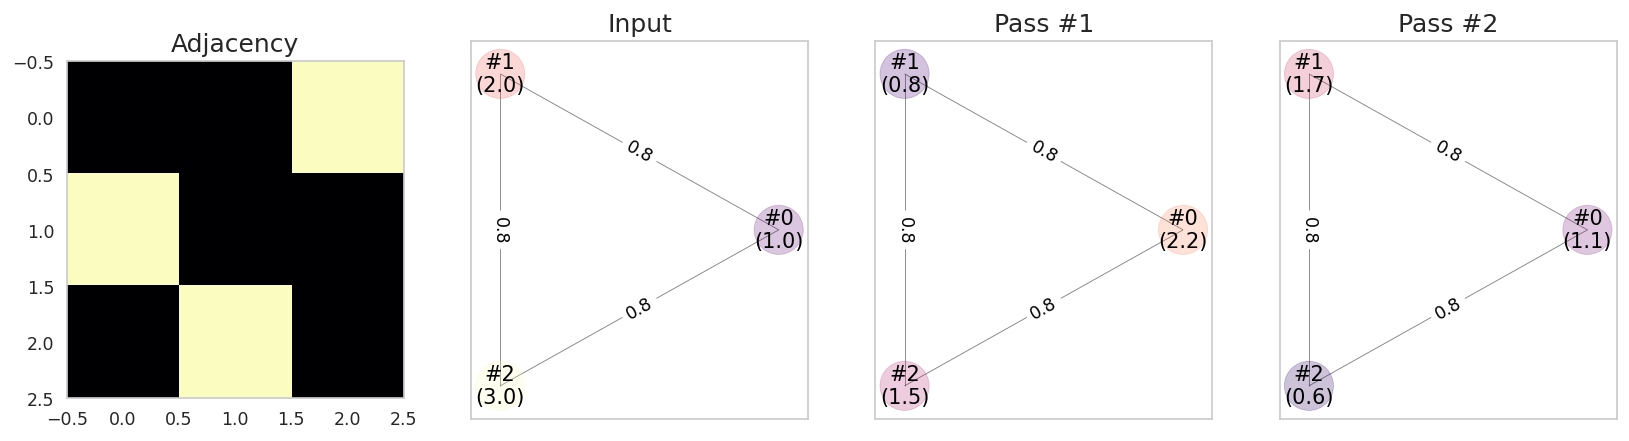

In [ ]:
offset_adj = 0.75*np.roll(np.eye(3), shift=1, axis=0)
offset_node = 1+np.arange(3).reshape((-1, 1))
show_model_results(offset_node, offset_adj, model, max_val=3)

# Simple 3x3 Convolution

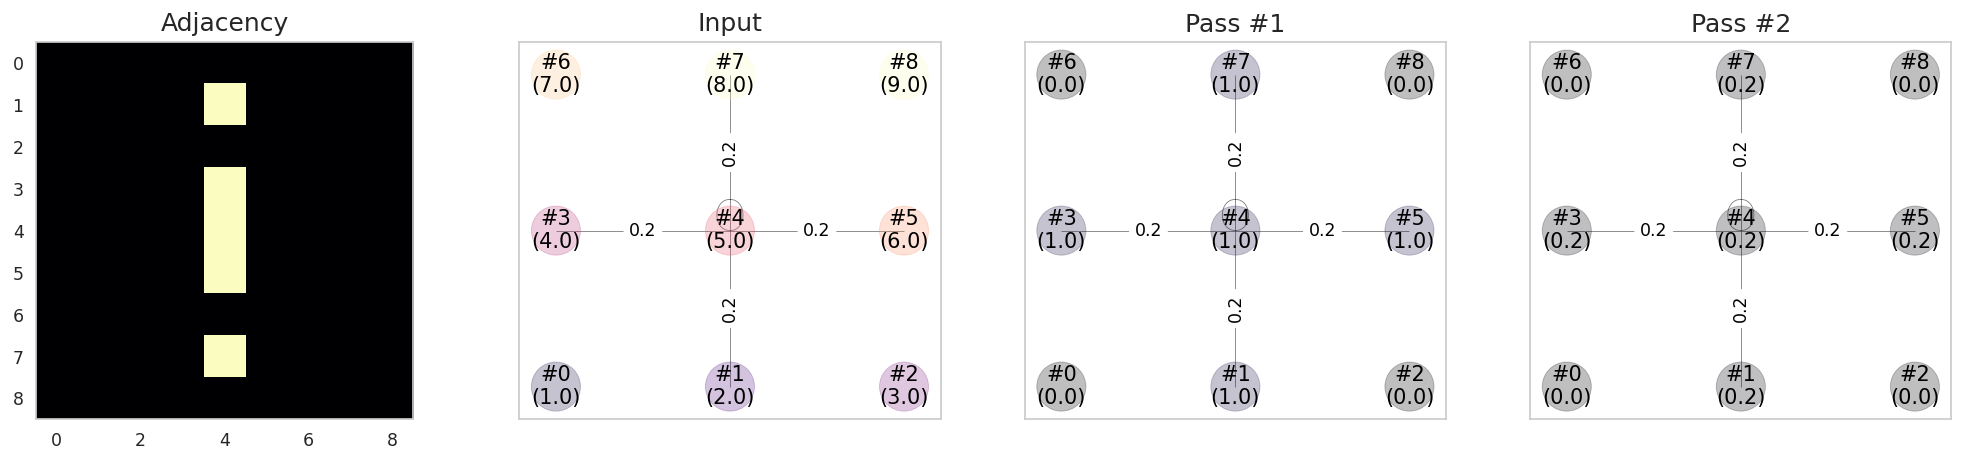

In [ ]:
xx, yy = [ax.ravel() for ax in np.meshgrid(np.arange(3), np.arange(3))]
org_dist = np.sqrt(np.square(xx.ravel()-1)+np.square(yy.ravel()-1))
full_adj = np.zeros((9, 9))
full_adj[:, 4] = (org_dist<=1)/(org_dist<=1).sum()
unique_value_nodes = 1+np.arange(9).reshape((-1, 1))

show_model_results(unique_value_nodes, 
                   full_adj, 
                   model, 
                   figsize=(20, 4), 
                   pos=np.stack([xx.ravel(), yy.ravel()], -1),
                  max_val=8
                  )

- Make the first node empty 

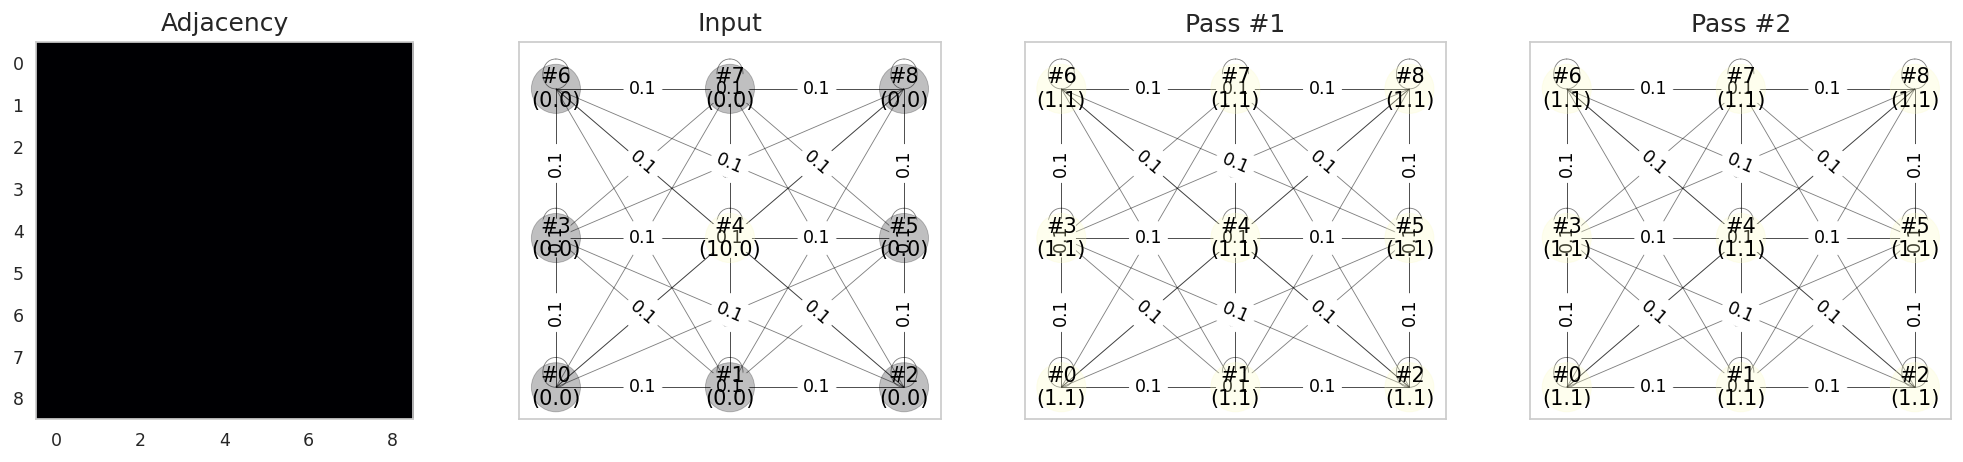

In [ ]:
full_adj = np.ones((9, 9))/9.0
mnz_feature = 10*(unique_value_nodes==5)
show_model_results(mnz_feature, 
                   full_adj, 
                   model, 
                   figsize=(20, 4), 
                   pos=np.stack([xx.ravel(), yy.ravel()], -1),
                  max_val=1
                  )